<a href="https://colab.research.google.com/github/vaibhavsinghmq/datascience/blob/main/Age_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
from google.colab import drive
import random

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [2]:
image_size = 100
dataset_directory = '/content/drive/My Drive/ms/COMP8220/'  # change to your own directory

age_ranges = {
    (6,20) : 0, 
    (35,40) : 1, 
    (55,98) : 2
}

def convert_ranges(age):
  for key in age_ranges:
    if key[0] <= age <= key[1]:
      return age_ranges[key]


def transform_labels_age(labels_vec):
  new_labels_vec = []
  for x in labels_vec:
    x2 = x.split('-')
    new_labels_vec.append(convert_ranges(int(x2[1])))
  return np.array(new_labels_vec)

def transform_labels(labels_vec):
  return transform_labels_age(labels_vec)


In [3]:
images_train = np.load(join(dataset_directory, 'train_images.npy'))
images_train = images_train.reshape([-1, image_size, image_size, 3]) / 255.0

labels_train_full = np.load(join(dataset_directory, 'train_labels.npy'))
labels_train = transform_labels(labels_train_full)

images_val = np.load(join(dataset_directory, 'val_images.npy'))
images_val = images_val.reshape([-1, image_size, image_size, 3]) / 255.0
labels_val_full = np.load(join(dataset_directory, 'val_labels.npy'))
labels_val = transform_labels(labels_val_full)

images_test_public = np.load(join(dataset_directory, 'test_images.npy'))
images_test_public = images_test_public.reshape([-1, image_size, image_size, 3]) / 255.0





print(images_train.shape)
print(images_val.shape)
print(images_test_public.shape)
print(labels_val_full[:9])
print(labels_val[:9])


(13475, 100, 100, 3)
(2595, 100, 100, 3)
(2374, 100, 100, 3)
['12626-16' '12726-37' '12726-37' '12726-37' '12726-37' '12726-37'
 '12726-37' '12726-39' '12726-37']
[0 1 1 1 1 1 1 1 1]


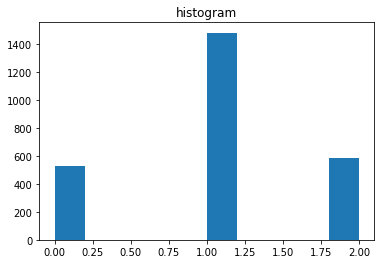

In [4]:
plt.hist(labels_val) 
plt.title("histogram") 
plt.show()

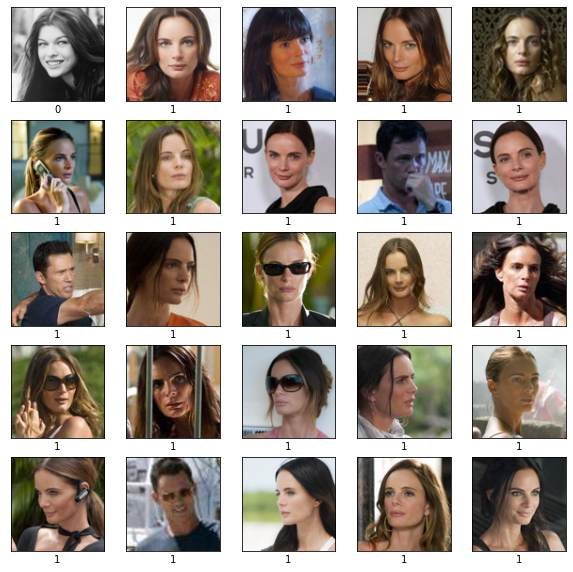

In [5]:
plt.figure(figsize=(10,10))
offset = 0
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_val[i+offset], cmap=plt.get_cmap('gray'))
    plt.xlabel(labels_val[i+offset])
plt.show()

In [6]:
#Reshaping the train file into a 2D array
nsamples, nx, ny,dim = images_train.shape
nsamples1, nx1, ny1,dim1 = images_val.shape
nsamples2, nx2, ny2,dim2 = images_test_public.shape

images_train2 = images_train.reshape((nsamples,-1))
images_val2 = images_val.reshape((nsamples1,-1))
images_test_public2 = images_test_public.reshape((nsamples2,-1))

print(images_train2.shape)
print(images_val2.shape)
print(images_test_public2.shape)


(13475, 30000)
(2595, 30000)
(2374, 30000)


In [7]:
# Create Train, Test, and Validation datasets
train_size = 128
test_size = 20

# Challenge 1

In [8]:
print(images_train.shape)
print(labels_train.shape)

(13475, 100, 100, 3)
(13475,)


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((images_train, labels_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((images_val[:595], labels_val[:595]))
test_dataset = tf.data.Dataset.from_tensor_slices((images_val[:2000], labels_val[:2000]))


TRAIN_DATASET_SIZE = len(train_dataset)
VALIDATION_DATASET_SIZE = len(validation_dataset)
TEST_DATASET_SIZE = len(test_dataset)


BATCH_SIZE = 128

train_dataset = train_dataset.shuffle(TRAIN_DATASET_SIZE).batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

VALIDATION_STEPS = VALIDATION_DATASET_SIZE // BATCH_SIZE

In [10]:
itr=1
for element in train_dataset:
  if itr<5:
    #print(element)
    itr=itr+1
  else:
    break

## Test 1

In [18]:
#build
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(100, 100, 3)),
  tf.keras.layers.MaxPooling2D(2, 2),
  # The second convolution
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # The third convolution
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # The fourth convolution
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  # Flatten the results to feed into a DNN
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  # 512 neuron hidden layer
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')                             
  ])
#compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#train
model.fit(
    train_dataset,
    epochs=20, 
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS)

_, accuracy = model.evaluate(test_dataset)
print(f'The model accuracy is {accuracy * 100:0.1f}%')

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


106/106 [==============================] - 364s 3s/step - loss: 1.0486 - accuracy: 0.4790 - val_loss: 0.8973 - val_accuracy: 0.6758
Epoch 2/20
106/106 [==============================] - 364s 3s/step - loss: 0.9882 - accuracy: 0.5216 - val_loss: 0.8974 - val_accuracy: 0.6562
Epoch 3/20
106/106 [==============================] - 368s 3s/step - loss: 0.9589 - accuracy: 0.5309 - val_loss: 0.8820 - val_accuracy: 0.6895
Epoch 4/20
106/106 [==============================] - 366s 3s/step - loss: 0.9315 - accuracy: 0.5454 - val_loss: 0.9477 - val_accuracy: 0.5312
Epoch 5/20
106/106 [==============================] - 368s 3s/step - loss: 0.9115 - accuracy: 0.5607 - val_loss: 0.7559 - val_accuracy: 0.7305
Epoch 6/20
106/106 [==============================] - 367s 3s/step - loss: 0.8861 - accuracy: 0.5702 - val_loss: 0.7952 - val_accuracy: 0.6992
Epoch 7/20
106/106 [==============================] - 365s 3s/step - loss: 0.8597 - accuracy: 0.5852 - val_loss: 0.8241 - val_accuracy: 0.6348
Epoch 8/20

In [19]:
model.save('age_model_20epochs.h5')

In [16]:
#build
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')                             
  ])
#compile
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#train
model.fit(
    train_dataset,
    epochs=1, 
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS)

_, accuracy = model.evaluate(test_dataset)
print(f'The model accuracy is {accuracy * 100:0.1f}%')

ValueError: ignored

## Test 2

In [ ]:


def Convolution(input_tensor,filters):

    x = Conv2D(filters=filters,kernel_size=(3, 3),padding = 'same',strides=(1, 1),kernel_regularizer=l2(0.001))(input_tensor)

    x = Dropout(0.1)(x)

    x= Activation('relu')(x)

    return x

def model(input_shape):

  inputs = Input((input_shape))

  conv_1= Convolution(inputs,32)

  maxp_1 = MaxPooling2D(pool_size = (2,2)) (conv_1)

  conv_2 = Convolution(maxp_1,64)

  maxp_2 = MaxPooling2D(pool_size = (2, 2)) (conv_2)

  conv_3 = Convolution(maxp_2,128)

  maxp_3 = MaxPooling2D(pool_size = (2, 2)) (conv_3)

  conv_4 = Convolution(maxp_3,256)

  maxp_4 = MaxPooling2D(pool_size = (2, 2)) (conv_4)

  flatten= Flatten() (maxp_4)

  dense_1= Dense(64,activation='relu')(flatten)

  dense_2= Dense(64,activation='relu')(flatten)

  drop_1=Dropout(0.2)(dense_1)

  drop_2=Dropout(0.2)(dense_2)

  output_1= Dense(1,activation="sigmoid",name='sex_out')(drop_1)

  output_2= Dense(1,activation="relu",name='age_out')(drop_2)

  model = Model(inputs=[inputs], outputs=[output_1,output_2])

  model.compile(loss=["binary_crossentropy","mae"], optimizer="Adam",

  metrics=["accuracy"])

  return model

In [ ]:
#Model=model((100,100,3))
#Model.summary()

In [ ]:
#Model.evaluate(X_test,Y_test_2)

In [ ]:
#pred4=model.predict(X_test)
#pred4[1]

In [ ]:
# Training the model
#hist2 = model2.fit(
#              train_dataset,
#              epochs=10,
#              validation_data=validation_dataset,
#              callbacks=callbacks).history
#hist2

## Result

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
                                    monitor='val_accuracy',
                                    patience=3)
callbacks = [
                early_stop
]

hist = model.fit(
              train_dataset,
              epochs=25,
              steps_per_epoch=20,
              validation_data=validation_dataset,
              callbacks=callbacks).history
hist

In [ ]:
#probabilities2 = model1.predict(images_test_public)
#predictions2 = np.argmax(probabilities2,axis=1)
#print(predictions2)
#print(len(predictions2))

In [ ]:
# Predict probabilites of test data.
#probabilities = model.predict(test_dataset)
# print(probabilities)
# Create classes from predictions
#predictions = np.argmax(probabilities,axis=1)
#actual_values = labels_val[:2000]
#print(actual_values)
#print(predictions)

In [20]:
probabilities1 = model.predict(images_test_public)
predictions1 = np.argmax(probabilities1,axis=1)
print(predictions1)
print(len(predictions1))

[1 2 2 ... 1 1 0]
2374


In [ ]:
#print(len(actual_values))
#print(len(predictions))

In [ ]:
#from sklearn import metrics
#print("balanced accuracy:   %0.3f" % metrics.balanced_accuracy_score(actual_values, predictions))
#print("accuracy:   %0.3f" % metrics.accuracy_score(actual_values, predictions))

In [ ]:
#model

In [21]:
f = open(join(dataset_directory, '46187618-DEEP-v1.csv'), 'w')
f.write('ID,Prediction\n')
for i in range(len(images_test_public)):
  f.write(str(i) + f',{predictions1[i]}\n')
f.close()